# Modélisation 

### Import des modules

In [3]:
import warnings
# Filtrer les avertissements spécifiques de LightGBM
warnings.filterwarnings("ignore", category=UserWarning)

In [42]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

#Imputation de mes données
from sklearn.impute import SimpleImputer

#Selection
from sklearn.model_selection import (
    train_test_split,
    GridSearchCV,
    LearningCurveDisplay,
    RandomizedSearchCV
)
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, mean_absolute_percentage_error, make_scorer

#Preprocess
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import LabelEncoder, RobustScaler, FunctionTransformer
from sklearn.pipeline import make_pipeline
# qui nous permettent une automatisation lors de transformation de variable
from sklearn.compose import make_column_transformer, make_column_selector

#Modèles
from sklearn.dummy import DummyRegressor
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor

# On utilisera la librairie de scipy.stats pour explorer des plages continues en échelle precis.
from scipy.stats import randint, uniform, loguniform

### Feature Engineering

A réaliser : Enrichir le jeu de données actuel avec de nouvelles features issues de celles existantes.
En règle générale : On utilise la méthode .apply() de Pandas pour créer une nouvelle colonne à partir d'une colonne existante. N'hésitez pas à regarder les exemples dans les chapitres de cours donnés en ressource

In [3]:
df_seattle = pd.read_csv('ville_de_seattle.csv')
df_seattle.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1080 entries, 0 to 1079
Data columns (total 9 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   PrimaryPropertyType        1080 non-null   object 
 1   YearBuilt                  1080 non-null   int64  
 2   NumberofBuildings          1080 non-null   float64
 3   NumberofFloors             1080 non-null   int64  
 4   LargestPropertyUseType     1080 non-null   object 
 5   LargestPropertyUseTypeGFA  1080 non-null   float64
 6   ENERGYSTARScore            717 non-null    float64
 7   SiteEnergyUseWN(kBtu)      1080 non-null   float64
 8   TotalGHGEmissions          1080 non-null   float64
dtypes: float64(5), int64(2), object(2)
memory usage: 76.1+ KB


In [5]:
'''D'après l'annova qu'on a effectue dans la partie precedent :
Stratifiez sur PrimaryPropertyType car elle présente le plus fort pouvoir explicatif (F le plus élevé).
Possède des effectifs relativement suffisants après traitement des rares'''
trainset, testset = train_test_split(df_seattle, test_size = 0.2, random_state=0, stratify=df_seattle['PrimaryPropertyType'])
print(trainset.shape)
print(testset.shape)

(864, 9)
(216, 9)


In [31]:
# Variante du MAPE pondérée par la somme des valeurs réelles.
def wape(y_true, y_pred):
    return np.sum(np.abs(y_true - y_pred)) / np.sum(np.abs(y_true)) * 100



# Fonction d'evaluation 
def evaluation(model, X_train, y_train, X_test, y_test):
    # Entraînement et prédiction
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    # Calcul des métriques
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    mae = mean_absolute_error(y_test, y_pred)
    mape = mean_absolute_percentage_error(y_test, y_pred) * 100
    wape_score = wape(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    # Affichage
    print(f"RMSE : {rmse:.4f}")
    print(f"MAE  : {mae:.4f}")
    print(f"MAPE : {mape:.2f}%")
    print(f"WAPE : {wape_score:.2f}%")
    print(f"R²   : {r2:.4f}")

    # Courbe d’apprentissage
    LearningCurveDisplay.from_estimator(model, X_train, y_train, cv=4, scoring='r2')
    plt.title("Learning Curve (R²)")
    plt.tight_layout()
    plt.show()

    print("=" * 100)

## Modelisation de Consommation d'energie

### Préparation des features pour la modélisation

A réaliser :
* Si ce n'est pas déjà fait, supprimer toutes les colonnes peu pertinentes pour la modélisation.
* Tracer la distribution de la cible pour vous familiariser avec l'ordre de grandeur. En cas d'outliers, mettez en place une démarche pour les supprimer.
* Débarrassez-vous des features redondantes en utilisant une matrice de corrélation de Pearson. Pour cela, utiisez la méthode corr() de Pandas, couplé d'un graphique Heatmap de la librairie Seaborn 
* Réalisez différents graphiques pour comprendre le lien entre vos features et la target (boxplots, scatterplots, pairplot si votre nombre de features numériques n'est pas très élevé).
*  Séparez votre jeu de données en un Pandas DataFrame X (ensemble de feautures) et Pandas Series y (votre target).
* Si vous avez des features catégorielles, il faut les encoder pour que votre modèle fonctionne. Les deux méthodes d'encodage à connaitre sont le OneHotEncoder et le LabelEncoder

In [14]:
def label_encode_columns(df):
    df_encoded = df.copy()
    for col in df_encoded.columns:
        le = LabelEncoder()
        df_encoded[col] = le.fit_transform(df_encoded[col].astype(str))
    return df_encoded

# Sélecteurs
num_selector = make_column_selector(dtype_include=[np.number])
cate_selector = make_column_selector(dtype_exclude=[np.number])

# Pipeline numérique
num_pipeline = make_pipeline(
    SimpleImputer(strategy='median'),
    RobustScaler()
)

# Pipeline catégoriel - LabelEncoder
label_pipeline = make_pipeline(
    FunctionTransformer(label_encode_columns, validate=False)
)

# Assembleur
preprocessor = make_column_transformer(
    (num_pipeline, num_selector),
    (label_pipeline, cate_selector),
    verbose_feature_names_out=False
)

### Comparaison de différents modèles supervisés

A réaliser :
* Pour chaque algorithme que vous allez tester, vous devez :
    * Réaliser au préalable une séparation en jeu d'apprentissage et jeu de test via une validation croisée.
    * Si les features quantitatives que vous souhaitez utiliser ont des ordres de grandeur très différents les uns des autres, et que vous utilisez un algorithme de regression qui est sensible à cette différence, alors il faut réaliser un scaling (normalisation) de la donnée au préalable.
    * Entrainer le modèle sur le jeu de Train
    * Prédire la cible sur la donnée de test (nous appelons cette étape, l'inférence).
    * Calculer les métriques de performance R2, MAE et RMSE sur le jeu de train et de test.
    * Interpréter les résultats pour juger de la fiabilité de l'algorithme.
* Vous pouvez choisir par exemple de tester un modèle linéaire, un modèle à base d'arbres et un modèle de type SVM
* Déterminer le modèle le plus performant parmi ceux testés.

In [18]:
# CODE COMPARAISON DES MODELES
dummy = make_pipeline(preprocessor, DummyRegressor())
linear = make_pipeline(preprocessor, LinearRegression())
svr = make_pipeline(preprocessor, SVR())
random_F = make_pipeline(preprocessor, RandomForestRegressor(random_state=0))
xgb = make_pipeline(preprocessor, XGBRegressor(random_state=0))
g_boost= make_pipeline(preprocessor,GradientBoostingRegressor(random_state=0))
# régroupons nos models dans un dict
dict_of_models = {'Dummy' : dummy,
                  'Linear' : linear,
                  'SVR' : svr,
                  'RandomForest': random_F,
                  'XGB': xgb,
                 'GradiantBoosting': g_boost}

In [20]:
# Préparation des features pour la modélisation
# Version sans la variable 'ENERGYSTARScore'
X_train = trainset.drop(columns=['SiteEnergyUseWN(kBtu)', 'TotalGHGEmissions', 'ENERGYSTARScore'])
X_test = testset.drop(columns=['SiteEnergyUseWN(kBtu)', 'TotalGHGEmissions', 'ENERGYSTARScore'])

# Version alternative avec 'ENERGYSTARScore' (pour tester son impact)
X_train_opt = trainset.drop(columns=['SiteEnergyUseWN(kBtu)', 'TotalGHGEmissions'])
X_test_opt = testset.drop(columns=['SiteEnergyUseWN(kBtu)', 'TotalGHGEmissions'])

# Définition de la cible (énergie consommée par site)
y_train = trainset['SiteEnergyUseWN(kBtu)']
y_test  = testset ['SiteEnergyUseWN(kBtu)']

Dummy
RMSE : 22816610.677236095
MAE : 8951560.31602405
MAPE : 1.8007330047837988e+22
WAPE: 102.07%
R² : -3.431367924133788e-05


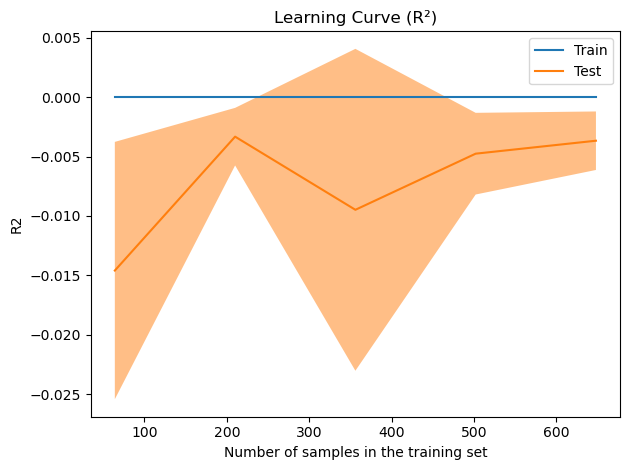

Linear
RMSE : 14697646.88331023
MAE : 5405644.30196559
MAPE : 4.394905232225384e+22
WAPE: 61.64%
R² : 0.585038068904197


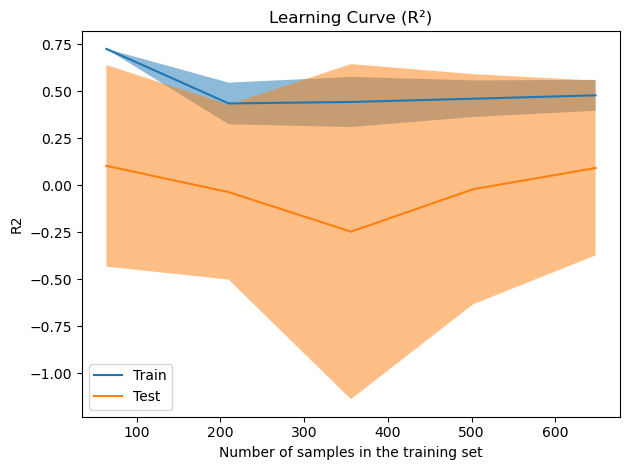

SVR
RMSE : 23409895.561316997
MAE : 7189355.716050265
MAPE : 7.363482776945726e+21
WAPE: 81.97%
R² : -0.052716888465109246


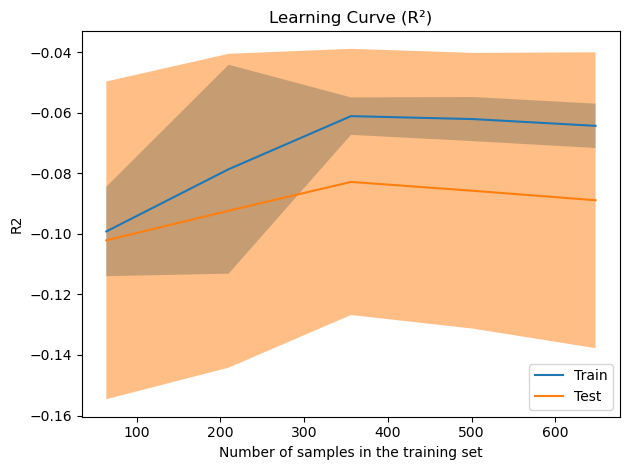

RandomForest
RMSE : 15877699.9278194
MAE : 4934944.871236874
MAPE : 4.4738125952975855e+22
WAPE: 56.27%
R² : 0.5157297189687753


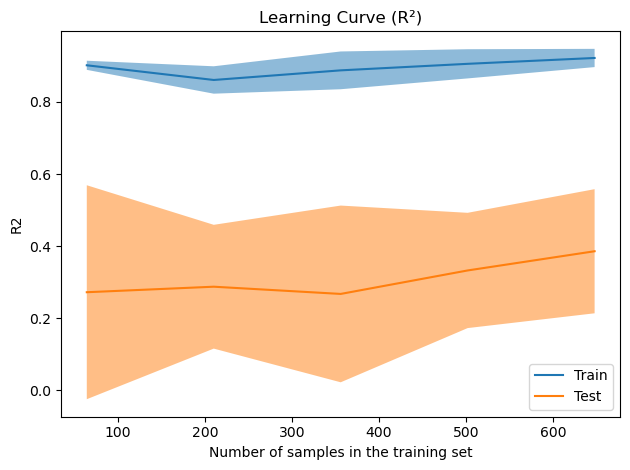

XGB
RMSE : 20294057.269161366
MAE : 5910290.213674754
MAPE : 4.095438393141908e+22
WAPE: 67.39%
R² : 0.20886535907647796


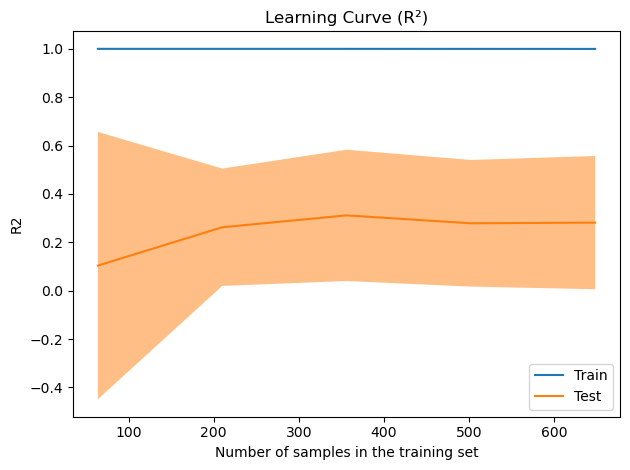

GradiantBoosting
RMSE : 19085976.215667944
MAE : 5830236.814778276
MAPE : 3.7243290805416206e+22
WAPE: 66.48%
R² : 0.30025243724445405


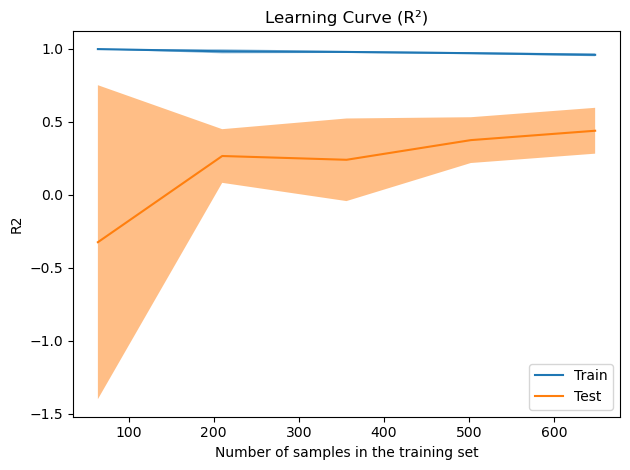

In [27]:
# Entrainnement et évaluation de nos models avec la variable 'ENERGYSTARScore'
for name, model in dict_of_models.items():
    print(name)
    evaluation(model, X_train_opt, y_train, X_test_opt, y_test)

Dummy
RMSE : 22816610.6772
MAE  : 8951560.3160
MAPE : 18007330047837987667968.00%
WAPE : 102.07%
R²   : -0.0000


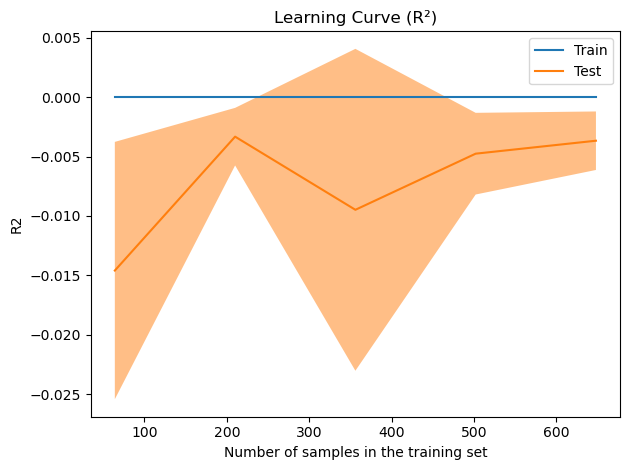

Linear
RMSE : 14827187.0758
MAE  : 5377159.8514
MAPE : 43180151432823428874240.00%
WAPE : 61.31%
R²   : 0.5777


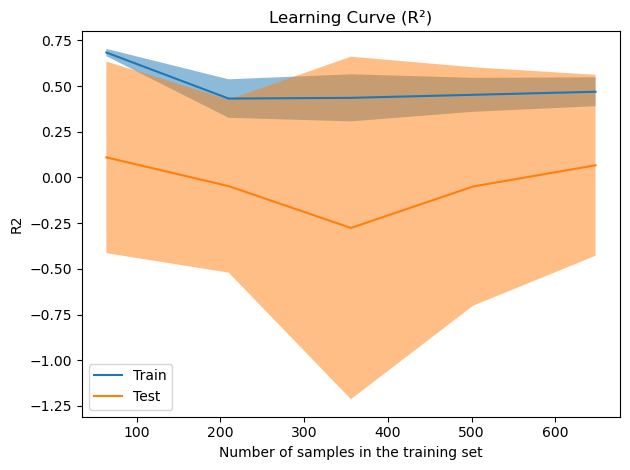

SVR
RMSE : 23409895.6421
MAE  : 7189354.5084
MAPE : 7363488352470271262720.00%
WAPE : 81.97%
R²   : -0.0527


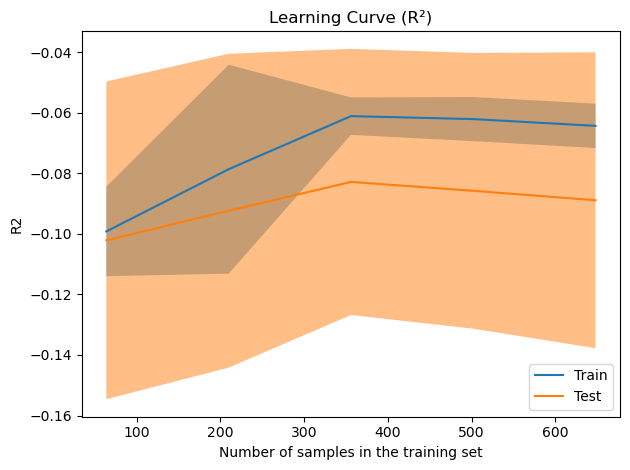

RandomForest
RMSE : 9636805.6511
MAE  : 4402300.1532
MAPE : 35222515482251000545280.00%
WAPE : 50.20%
R²   : 0.8216


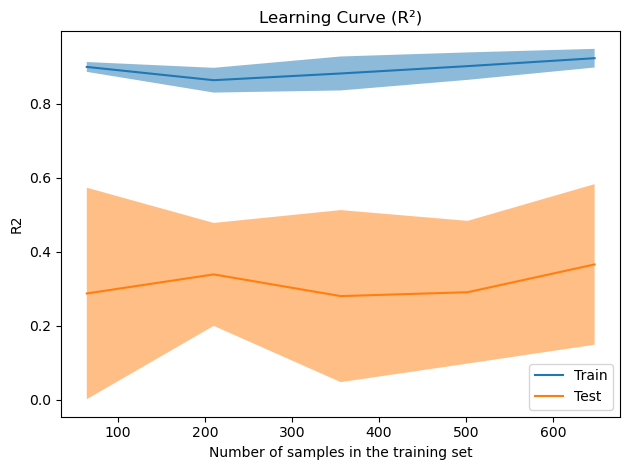

XGB
RMSE : 12690642.3726
MAE  : 4771416.7191
MAPE : 41000291457620674347008.00%
WAPE : 54.40%
R²   : 0.6906


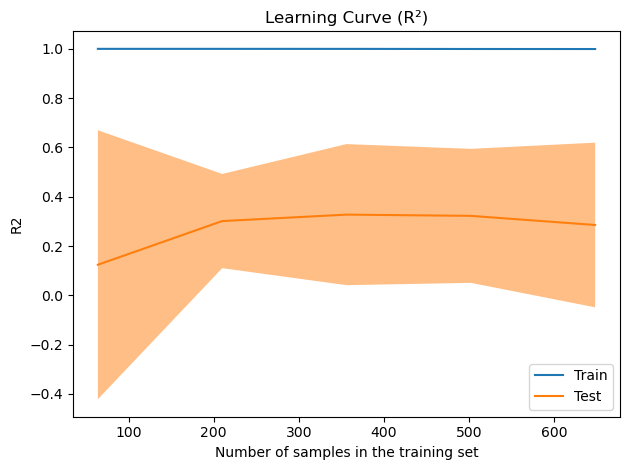

GradiantBoosting
RMSE : 11355562.2960
MAE  : 4771576.9171
MAPE : 38466665547985609293824.00%
WAPE : 54.41%
R²   : 0.7523


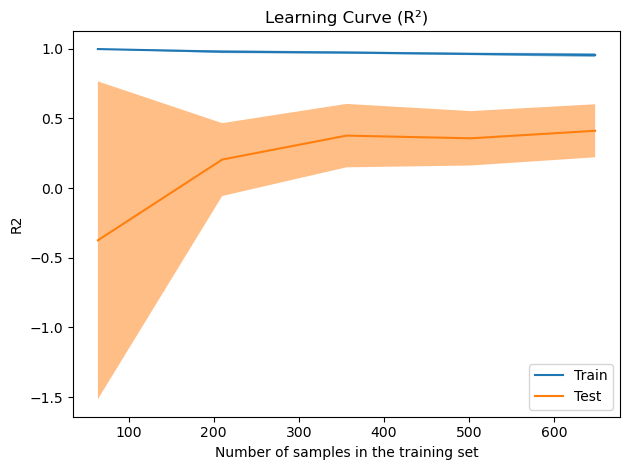

In [33]:
# Entrainnement et évaluation de nos models sans la variable 'ENERGYSTARScore'
for name, model in dict_of_models.items():
    print(name)
    evaluation(model, X_train, y_train, X_test, y_test)

CE QU'ON OBSERVE :
- Random Forest explose littéralement en performance sans ENERGYSTARScore (gagne plus de 0.31 en R²).
- Gradient Boosting et XGBoost s’améliorent beaucoup également.
- Linear Regression reste stable.
- SVR ne parvient pas à modéliser la complexité du problème (R² < 0).

CONCLUSION :
- je dois continuer l’optimisation sans inclure `ENERGYSTARScore`, car elle semble introduire plus de bruit que d'information utile.
- RandomForest = meilleur modèle actuel selon RMSE, MAE, WAPE et R².
- MAPE ne nous apporte aucune info utile ici à cause des valeurs proches de zéro -> à remplacer par WAPE ou SMAPE pour notre rapport.
- Les autres modèles montrent que la complexité ne garantit pas la performance (SVR est catastrophique ici).

* Voici les deux model choisie pour optimisation : `RandomForest` et `GradientBoosting`

### Optimisation et interprétation du modèle

**METHODE OPTIMISATION :**
* Pour optimiser les hyperparamètres de mes modèles, j’ai adopté une démarche progressive en deux étapes : une première phase d’exploration large avec RandomizedSearchCV afin d’identifier les zones prometteuses dans l’espace des paramètres, suivie d’une phase de recherche plus ciblée avec GridSearchCV utilisant des listes explicites, resserrant ainsi la recherche autour des meilleurs paramètres trouvés pour affiner la performance du modèle.

#### OPTIMISATION DU MODEL `RANDOMFOREST`

In [44]:
# Dictionnaire de scorers
scoring = {
    'R2': make_scorer(r2_score),
    'RMSE': make_scorer(lambda y_test, y_pred: np.sqrt(mean_squared_error(y_test, y_pred)),
                        greater_is_better=False),
    'MAE': make_scorer(mean_absolute_error, greater_is_better=False),
    'WAPE': make_scorer(lambda y_test, y_pred: wape(y_test, y_pred),
                        greater_is_better=False)
}

Fitting 5 folds for each of 100 candidates, totalling 500 fits
{'randomforestregressor__bootstrap': False, 'randomforestregressor__max_depth': 11, 'randomforestregressor__max_features': 0.3, 'randomforestregressor__min_samples_leaf': 1, 'randomforestregressor__min_samples_split': 2, 'randomforestregressor__n_estimators': 279}
RMSE : 8911082.1729
MAE  : 4301878.0830
MAPE : 33336074514563824877568.00%
WAPE : 49.05%
R²   : 0.8475


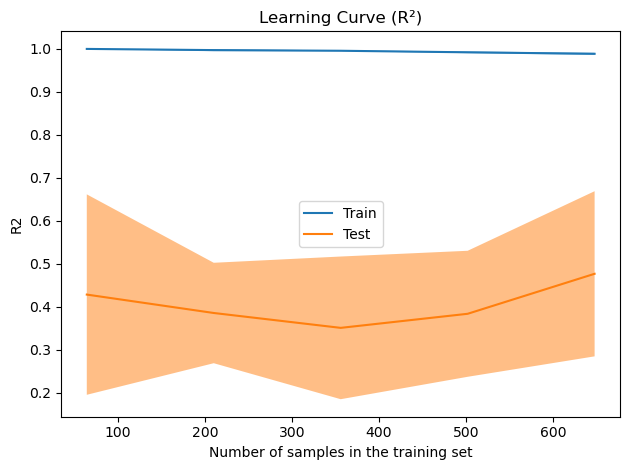

In [46]:
# CODE OPTIMISATION ET INTERPRETATION DU MODELE RandomForest
# 1. Définition de la distribution des hyperparamètres
param_dist_rf = {
    'randomforestregressor__n_estimators': randint(100, 400),       # défaut = 100
    'randomforestregressor__max_depth': randint(3, 20),             # défaut = None
    'randomforestregressor__min_samples_split': randint(2, 10),     # défaut = 2
    'randomforestregressor__min_samples_leaf': randint(1, 10),      # défaut = 1
    'randomforestregressor__max_features': ['sqrt', 'log2', None, 0.3, 0.7],
    'randomforestregressor__bootstrap': [True, False]               # défaut = True
}

# 2. Configuration de RandomizedSearchCV
grid_RS = RandomizedSearchCV(random_F, param_dist_rf, n_iter=100, cv=5, scoring=scoring,
    refit='RMSE',  # On optimise sur RMSE pour éviter surapprentissage
    n_jobs=-1, verbose=2, random_state=0)

grid_RS.fit(X_train, y_train)

print(grid_RS.best_params_)
evaluation(grid_RS.best_estimator_, X_train, y_train, X_test, y_test)

Fitting 4 folds for each of 324 candidates, totalling 1296 fits
{'randomforestregressor__bootstrap': False, 'randomforestregressor__max_depth': 9, 'randomforestregressor__max_features': 0.4, 'randomforestregressor__min_samples_leaf': 1, 'randomforestregressor__min_samples_split': 2, 'randomforestregressor__n_estimators': 260}
RMSE : 9319323.7850
MAE  : 4392640.1768
MAPE : 34820234770350723825664.00%
WAPE : 50.09%
R²   : 0.8332


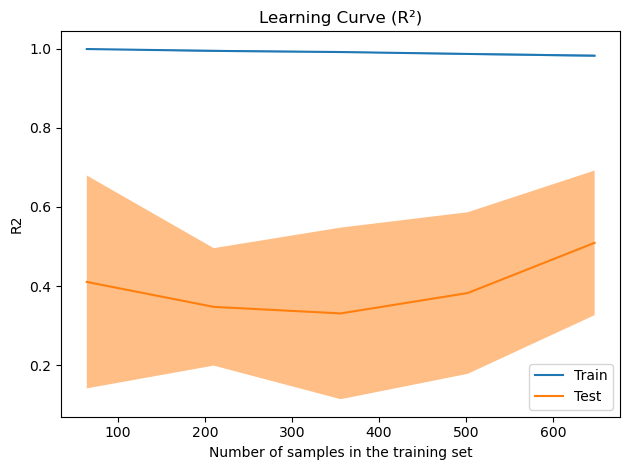

In [52]:
param_grid_rf = {
    'randomforestregressor__bootstrap': [False, True],  
    'randomforestregressor__max_depth': [9, 11, 13],    # ±2 autour de 11
    'randomforestregressor__max_features': [0.2, 0.3, 0.4],  # centré sur 0.3
    'randomforestregressor__min_samples_leaf': [1, 2],  # autour de 1
    'randomforestregressor__min_samples_split': [2, 3, 4],  # autour de 2
    'randomforestregressor__n_estimators': [260, 279, 300]  # autour de 279
}


grid_GS = GridSearchCV(
    random_F, param_grid_rf, cv=4, scoring=scoring, refit='RMSE', 
    n_jobs=-1, verbose=2)

grid_GS.fit(X_train, y_train)

print(grid_GS.best_params_)
evaluation(grid_GS.best_estimator_, X_train, y_train, X_test, y_test)

#### OPTIMISATION DU MODEL `GradiantBoosting`

Fitting 5 folds for each of 100 candidates, totalling 500 fits
{'gradientboostingregressor__learning_rate': 0.2986517645423626, 'gradientboostingregressor__max_depth': 5, 'gradientboostingregressor__min_samples_leaf': 1, 'gradientboostingregressor__min_samples_split': 2, 'gradientboostingregressor__n_estimators': 17, 'gradientboostingregressor__subsample': 0.8585110363891627}
RMSE : 9026452.4803
MAE  : 4185672.3218
MAPE : 44621129050386616811520.00%
WAPE : 47.73%
R²   : 0.8435


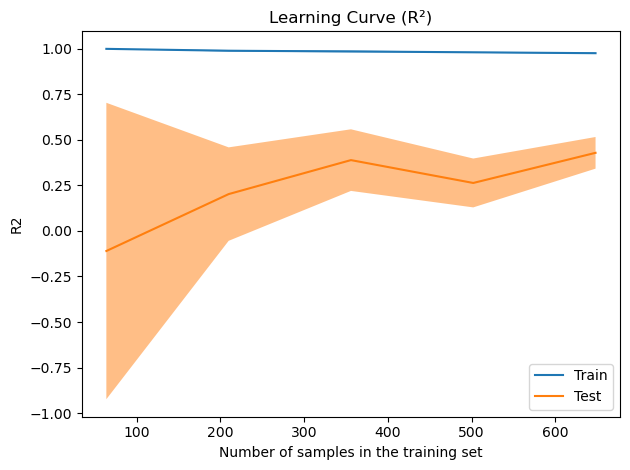

In [54]:
# CODE OPTIMISATION ET INTERPRETATION DU MODELE GradientBoosting
param_dist_gb = {
    'gradientboostingregressor__n_estimators':    randint(10, 20),     # default = 100
    'gradientboostingregressor__learning_rate':    uniform(0.01, 0.3),  # default = 0.1
    'gradientboostingregressor__max_depth':        randint(2, 8),       # default = 3
    'gradientboostingregressor__subsample':        uniform(0.7, 0.3),   # default = 1.0
    'gradientboostingregressor__min_samples_split':randint(2, 10),      # default = 2
    'gradientboostingregressor__min_samples_leaf': randint(1, 10)       # default = 1
}



grid_RS = RandomizedSearchCV(
    g_boost, param_dist_gb, n_iter=100, cv=5, scoring=scoring,
    refit='RMSE',  # On optimise sur RMSE pour éviter surapprentissage
    n_jobs=-1, verbose=2, random_state=42
)

grid_RS.fit(X_train, y_train)

print(grid_RS.best_params_)
evaluation(grid_RS.best_estimator_, X_train, y_train, X_test, y_test)

Fitting 4 folds for each of 486 candidates, totalling 1944 fits
{'gradientboostingregressor__learning_rate': 0.3, 'gradientboostingregressor__max_depth': 6, 'gradientboostingregressor__min_samples_leaf': 1, 'gradientboostingregressor__min_samples_split': 4, 'gradientboostingregressor__n_estimators': 20, 'gradientboostingregressor__subsample': 0.9}
RMSE : 10751146.1292
MAE  : 4545935.7325
MAPE : 31799587055075336388608.00%
WAPE : 51.83%
R²   : 0.7780


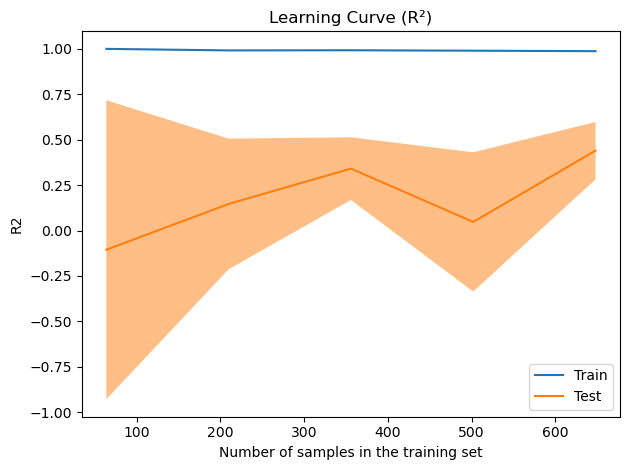

In [58]:
param_dist_gb = {
    'gradientboostingregressor__learning_rate': [0.25, 0.3, 0.35],        # autour de 0.2986
    'gradientboostingregressor__max_depth': [4, 5, 6],                   # ±1 autour de 5
    'gradientboostingregressor__min_samples_leaf': [1, 2],               # autour de 1
    'gradientboostingregressor__min_samples_split': [2, 3, 4],           # autour de 2
    'gradientboostingregressor__n_estimators': [15, 17, 20],             # autour de 17
    'gradientboostingregressor__subsample': [0.8, 0.85, 0.9]             # autour de 0.8585
}

grid_GS = GridSearchCV(
    g_boost, param_dist_gb, cv=4, scoring=scoring,
    refit='RMSE',  # On optimise sur RMSE pour éviter surapprentissage 
    n_jobs=-1, verbose=2)

grid_GS.fit(X_train, y_train)

print(grid_GS.best_params_)
evaluation(grid_GS.best_estimator_, X_train, y_train, X_test, y_test)

## Interpretation de notre model final

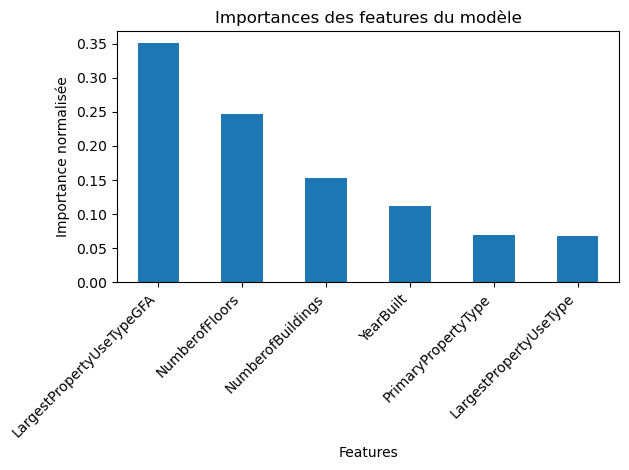

In [60]:
final_model = make_pipeline(preprocessor, RandomForestRegressor(bootstrap = False, max_depth = 11, max_features = 0.3,
                                min_samples_leaf = 1, min_samples_split = 2, n_estimators = 279, random_state=0))
final_model.fit(X_train,y_train)

# 1. Extraction de la liste des colonnes numériques et catégorielles
num_cols = X_train.select_dtypes(include=[np.number]).columns.tolist()
cat_cols = X_train.select_dtypes(exclude=[np.number]).columns.tolist()
# 2. Construisons la liste finale dans l’ordre d’application du ColumnTransformer
feature_names = num_cols + cat_cols

# 3. Récupérons l’estimateur RandomForest du pipeline
rf = final_model.named_steps['randomforestregressor']

# 4. Créons la Series d’importances
importances = pd.Series(rf.feature_importances_, index=feature_names)
importances = importances.sort_values(ascending=False)

# 4. Visualisons
importances.plot.bar()
plt.title("Importances des features du modèle")
plt.ylabel("Importance normalisée")
plt.xlabel("Features")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

* La surface de la plus grande utilisation (`LargestPropertyUseTypeGFA`) est de loin la variable la plus influente sur votre cible.
* Le nombre d’étages (`NumberofFloors`) et le nombre de bâtiments (`NumberofBuildings`) arrivent en deuxième et troisième position, soulignant l’impact de l’échelle verticale et horizontale du site.
* L’année de construction (`YearBuilt`) figure au milieu de l’échelle, ce qui suggère qu’elle contribue modérément – peut-être via l’efficacité énergétique ou le type de matériaux employés.
* Le type de propriété principal (`PrimaryPropertyType`) et la catégorie principale d’usage (LargestPropertyUseType) ont une influence plus limitée, mais restent non négligeables.